In [ ]:
import sys

In [ ]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== START ========== ###
sys.path += ['/content/drive/My Drive/Colab Notebooks'] 
### ========== END ========== ###


In [ ]:
from nutil import *

In [ ]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

In [ ]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [ ]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set
        d = {}
        c = Counter(y)
        d[0] = c[0]/len(y)
        d[1] = c[1]/len(y)
        self.probabilities_ = d

        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)
        n,_ = X.shape
        y = []
        for _ in range(n):
          y.append(np.random.choice([0,1],p=[self.probabilities_[0], self.probabilities_[1]]))
        
        ### ========== TODO : END ========== ###

        return y


In [ ]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels


In [ ]:
######################################################################
# Mutatble functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    # hint: use train_test_split (be careful of the parameters)
    splitter = StratifiedShuffleSplit(n_splits=ntrials, test_size=test_size, random_state=0)
    train_error, test_error, f1_score = 0, 0, 0
    for train, test in splitter.split(X, y):
      clf.fit(X[train], y[train])

      y_train  = clf.predict(X[train])
      y_test = clf.predict(X[test])

      train_error += 1 - metrics.accuracy_score(y[train], y_train, normalize = True)
      test_error  += 1 - metrics.accuracy_score(y[test], y_test, normalize = True)
      f1_score += metrics.f1_score(y[test], y_test, average = 'micro')

    train_error /= ntrials
    test_error /= ntrials
    f1_score /= ntrials
    ### ========== END ========== ###

    return train_error, test_error, f1_score




In [ ]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()


Plotting...


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Classifying using Majority Vote...
	-- training error: 0.240
Classifying using Random...
	-- training error: 0.374
Classifying using Decision Tree...
	-- training error: 0.000
Classifying using 3-Nearest Neighbors...
	-- training error: 0.114
Classifying using 5-Nearest Neighbors...
	-- training error: 0.129
Classifying using 7-Nearest Neighbors...
	-- training error: 0.152
Investigating various classifiers...
Cross-validating Majority Classifer...
	-- train error: 0.240
	-- test error: 0.240
	-- f1 score: 0.760
Cross-validating Random Classifer...
	-- train error: 0.375
	-- test error: 0.382
	-- f1 score: 0.618
Cross-validating Decision Tree Classifer...
	-- train error: 0.000
	-- test error: 0.205
	-- f1 score: 0.795
Cross-validating 5-Nearest Neighbors Classifer...
	-- train error: 0.133
	-- test error: 0.209
	-- f1 score: 0.791
Finding the best k...


<Figure size 432x288 with 0 Axes>

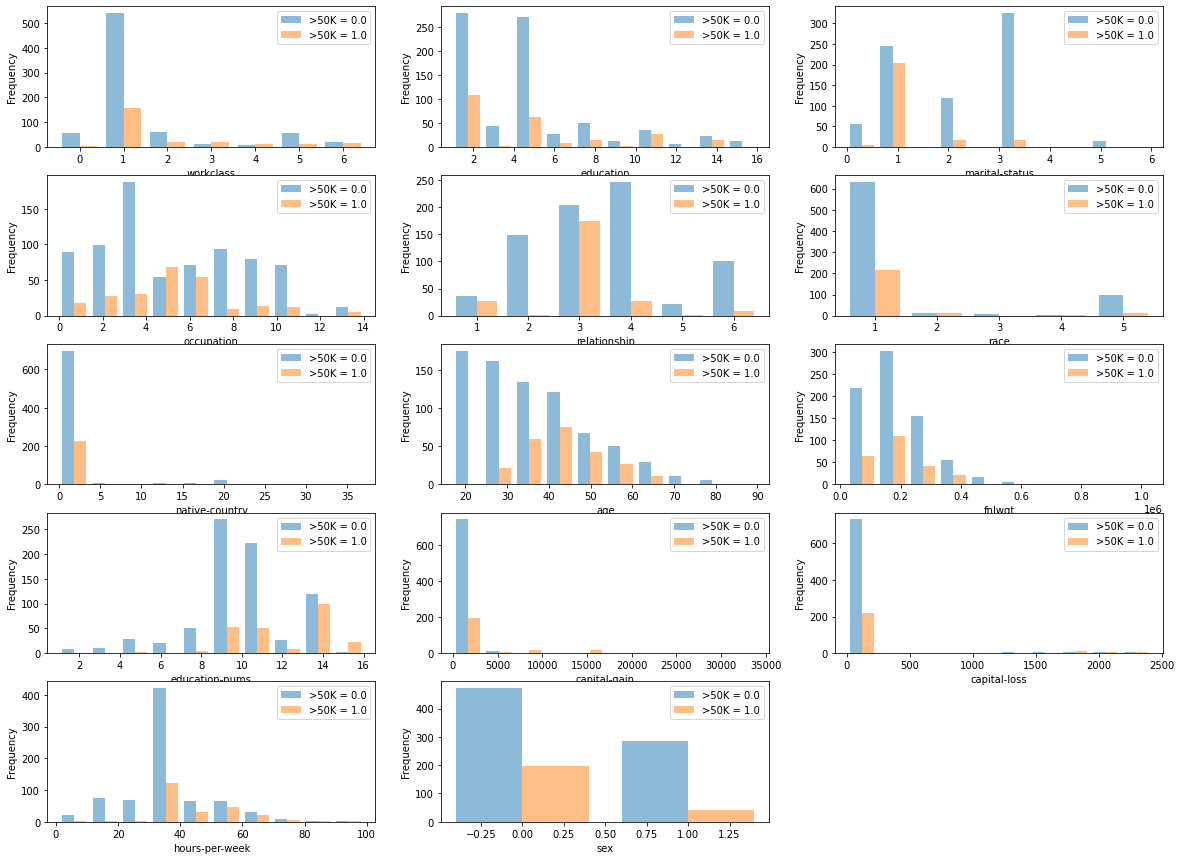

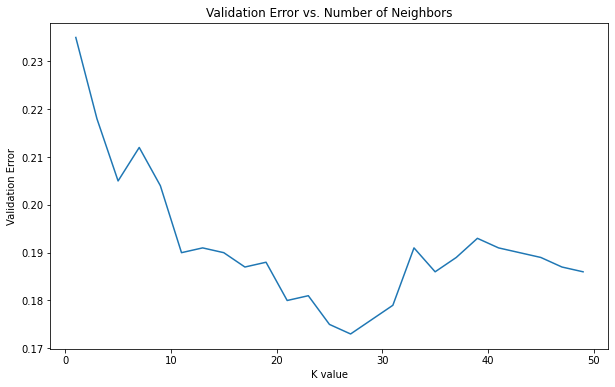

	 -- best k is 27 with an error of 0.17300000000000004
Investigating depths...


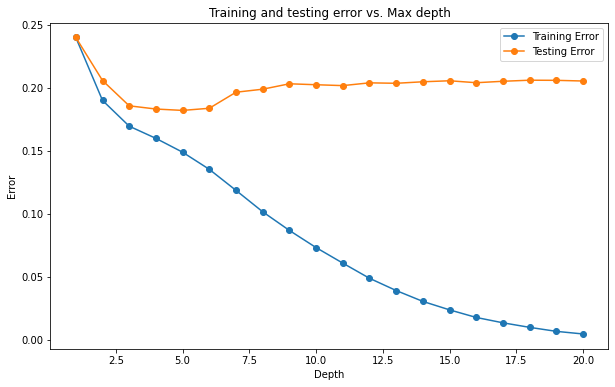

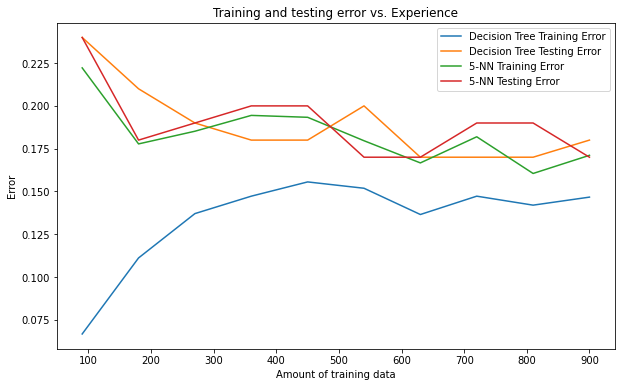

Done


In [ ]:

######################################################################
# main
######################################################################

def main():
    
    
    
    # load adult_subsample dataset with correct file path
    ### ========== START ========== ###
    data_file =  "/content/drive/My Drive/Colab Notebooks/adult_subsample.csv"
    ### ========== END ========== ###
    



    data = load_data(data_file, header=1, predict_col=-1)

    X = data.X; Xnames = data.Xnames
    y = data.y; yname = data.yname
    n,d = X.shape  # n = number of examples, d =  number of features

    

    plt.figure()
    #========================================
    # part a: plot histograms of each feature
    print('Plotting...')
    plot_histograms (X, y, Xnames=Xnames, yname=yname)
    




    ### ========== START ========== ###
    # part i: Preprocess X (e.g., normalize)
    X = StandardScaler().fit_transform(X)
    ### ========== END ========== ###




    #========================================
    # train Majority Vote classifier on data
    print('Classifying using Majority Vote...')
    clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
    clf.fit(X, y)                  # fit training data using the classifier
    y_pred = clf.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)





    ### ========== START ========== ###
    # part b: evaluate training error of Random classifier
    print('Classifying using Random...')
    clf  = RandomClassifier()
    clf.fit(X, y)
    y_pred = clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)
    ### ========== END ========== ###





    ### ========== START ========== ###
    # part c: evaluate training error of Decision Tree classifier
    print('Classifying using Decision Tree...')
    clf = DecisionTreeClassifier(criterion="entropy")
    clf.fit(X, y)
    y_pred = clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)
    ### ========== END ========== ###






    ### ========== START ========== ###
    # part d: evaluate training error of k-Nearest Neighbors classifier
    # use k = 3, 5, 7 for n_neighbors
    for k in [3,5,7]:
      print('Classifying using ' + str(k) + '-Nearest Neighbors...')
      clf = KNeighborsClassifier(k)
      clf.fit(X, y)
      y_pred = clf.predict(X)
      train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
      print('\t-- training error: %.3f' % train_error)
    ### ========== END ========== ###





    ### ========== START ========== ###
    # part e: use cross-validation to compute average training and test error of classifiers
    print('Investigating various classifiers...')

    majority_clf = MajorityVoteClassifier()
    train_error, test_error, f1 = error(majority_clf, X, y)
    print('Cross-validating Majority Classifer...')
    print('\t-- train error: %.3f' % train_error)
    print('\t-- test error: %.3f' % test_error)
    print('\t-- f1 score: %.3f' % f1)

    random_clf = RandomClassifier()
    train_error, test_error, f1 = error(random_clf, X, y)
    print('Cross-validating Random Classifer...')
    print('\t-- train error: %.3f' % train_error)
    print('\t-- test error: %.3f' % test_error)
    print('\t-- f1 score: %.3f' % f1)

    decision_tree_clf = DecisionTreeClassifier(criterion = 'entropy')
    train_error, test_error, f1 = error(decision_tree_clf, X, y)
    print('Cross-validating Decision Tree Classifer...')
    print('\t-- train error: %.3f' % train_error)
    print('\t-- test error: %.3f' % test_error)
    print('\t-- f1 score: %.3f' % f1)
    
    knn_clf = KNeighborsClassifier(5)
    train_error, test_error, f1 = error(knn_clf, X, y)
    print('Cross-validating 5-Nearest Neighbors Classifer...')
    print('\t-- train error: %.3f' % train_error)
    print('\t-- test error: %.3f' % test_error)
    print('\t-- f1 score: %.3f' % f1)

    ### ========== END ========== ###





    ### ========== START ========== ###
    # part f: use 10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    print('Finding the best k...')
    val_errors = []
    odds = [i for i in range(50) if i % 2 == 1]
    for i in odds:
      clf = KNeighborsClassifier(i)
      mean_acc = cross_val_score(clf, X, y, cv=10).mean()
      val_error = 1 - mean_acc
      val_errors.append(val_error)
    plt.figure(figsize=(10,6))
    plt.plot(odds, val_errors)
    plt.title("Validation Error vs. Number of Neighbors")
    plt.xlabel("K value")
    plt.ylabel("Validation Error")
    plt.show()
    print("\t -- best k is " + str(val_errors.index(min(val_errors)) * 2 + 1) + " with an error of " + str(min(val_errors)))
    ### ========== END ========== ###





    ### ========== START ========== ###
    # part g: investigate decision tree classifier with various depths
    print('Investigating depths...')
    train_errors = []
    test_errors = []
    depths = list(range(1,21))
    for i in depths:
      clf = DecisionTreeClassifier(criterion='entropy', max_depth=i)
      # scores = cross_validate(clf, X, y, cv=10, return_train_score=True)
      # train_error = 1 - scores["train_score"].mean()
      # test_error = 1 - scores["test_score"].mean()
      # train_errors.append(train_error)
      # test_errors.append(test_error)
      train_error, test_error, _ = error(clf, X, y)
      train_errors.append(train_error)
      test_errors.append(test_error)
    plt.figure(figsize=(10,6))
    plt.plot(depths, train_errors, label = "Training Error", marker = "o")
    plt.plot(depths, test_errors,  label = "Testing Error", marker = "o")
    plt.title("Training and testing error vs. Max depth")
    plt.xlabel("Depth")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

    ### ========== END ========== ###





    ### ========== START ========== ###
    # part h: investigate decision tree and k-Nearest Neighbors classifier with various training set sizes
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    for train, test in sss.split(X,y):
      X_train = X[train]
      X_test = X[test]
      y_train = y[train]
      y_test = y[test]

    amounts = [i*X_train.shape[0]/10 for i in range(1,11)]
    tree_trains = []
    tree_tests = []
    k_trains = []
    k_tests = []

    for amount in amounts:
      X_subset, y_subset = X_train[:int(amount)], y_train[:int(amount)]
      tree = DecisionTreeClassifier(criterion="entropy", max_depth=5, random_state=0)
      tree.fit(X_subset, y_subset)
      preds = tree.predict(X_subset)
      train_error = 1 - metrics.accuracy_score(y_subset, preds, normalize=True)
      preds_test = tree.predict(X_test)
      test_error = 1 - metrics.accuracy_score(y_test, preds_test, normalize=True)
      tree_trains.append(train_error)
      tree_tests.append(test_error)

      knn = KNeighborsClassifier(n_neighbors=27)
      knn.fit(X_subset, y_subset)
      preds = knn.predict(X_subset)
      train_error = 1 - metrics.accuracy_score(y_subset, preds, normalize=True)
      preds_test = knn.predict(X_test)
      test_error = 1 - metrics.accuracy_score(y_test, preds_test, normalize=True)
      k_trains.append(train_error)
      k_tests.append(test_error)

    plt.figure(figsize=(10,6))
    plt.plot(amounts, tree_trains, label = "Decision Tree Training Error")
    plt.plot(amounts, tree_tests, label = "Decision Tree Testing Error")
    plt.plot(amounts, k_trains, label = "5-NN Training Error")
    plt.plot(amounts, k_tests, label = "5-NN Testing Error")
    plt.title("Training and testing error vs. Experience")
    plt.xlabel("Amount of training data")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

    ### ========== END ========== ###
    print("Done")


if __name__ == "__main__":
    main()


workclass: The majority of people are self-employed-not-inc. Notably, almost everyone that works in the private sector make less than 50k, 
and people that work in federal or local government have a higher chance to make more than 50k than less than 50k.

education: Most people with education level Bachelors or 11th grade make less than 50k. The ratio of people who make less than and more than 50k is much closer to 1 for HS grad, Prof school,
Assoc-voc, and 7th-8th

marital status: Divorced people are most likely to make more than 50k; for all other marital statuses, one is much more likely to make less than 50k.
occupation: Sales and Exec-managerial are nearly equally likely to make more than 50k as they are to make less than; for all other occupations, one is much more likely to make less than 50k.

relationship: Husbands are nearly equally likely to make more than 50k as they are to make less than; for all other relationship statuses, one is more likely to make less than.

race: White and black people are much more likely to make less than 50; for other races (Asians and Other) are more equally likely to make more or less than 50k.

native country: Almost all people's native country is the US in this data set; one is more likely to make less than 50k.

age: As one gets older, one is less likely to make less than 50k; the age groups that are most likely to make more than 50k are 30, 40, and 50 year olds.

final weight: The census believes each entry represents less than 300k people most often; the entry that is most likely to make more than 50k out of all entries is the one that represents ~200k people.

education number: As the education number increases, one is more likely to make more than 50k.

capital gain: As the capital gain increases, one is more likely to make more than 50k.

capital loss: As the capital loss increases, one is more likely to make more than 50k.

hours per week: People that work less than 40 hours a week are very unlikely to make more than 50k. People that work 40-60 hours are more likely to make more than 50k than people who work other hours.

sex: Males are unlikely to make more than 50k, while females are somewhat more likely to make more than 50k.

A small k leads to a high validation error; this is because the model is overfitting with a small k and so the model is not generalizable to unseen data. A large k also is not the best k because it leads to underfitting; the decision boundary is too smooth. The best k is 15, with an error of 0.237.

The best depth to use is 5; too large of a max depth leads to overfitting, specifically greater than a depth of 5. We can see that there is overfitting because as the max depth increases, the training error decreases while the test error increases and then stagnates at around 0.21.

Training experience does not affect the KNN model as much as it affects the decision tree. For both KNN and decision tree, the training error increases as the amount of training data increases until over half of the training data is used, then stagnates at around 0.25 error for KNN and 0.15 error for the decision tree. For the decision tree, the testing error decreases with more training data, from above 0.25 error to below 0.2.